# Carbon Emissions vs Population

### Goals
This project aims to answer 2 questions
   - Rather the population size of a region has a relation to carbon emissions.
   - Was there a significant effect on carbon emissions based on year and state
    
### Project Members: 
   - [Laurent Mundell](https://github.com/LaurentStar)
   - [Lidet Alemu](https://github.com/Lidetsal)

### Table of Contents
    -Imports
    -Data Sources
    -Methods/Globals/Constants
    -Data Prep
    -Explore/Visual Data
    -Hypothesis Test I
    -Hypothesis Test II
    -Effect Size
    -Confident Interval

# Imports

In [123]:
import matplotlib.pyplot as plt
from PIL import Image

import statsmodels.api as sm
from statsmodels.formula.api import ols

from itertools import combinations
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle 
import requests
import seaborn as sns
from scipy import stats

%matplotlib inline

# Data Sources

   - [_**How States were catagorized**_](https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf)
   - [_**U.S. Energy Information Administration (eia) API**_](https://www.eia.gov/opendata/qb.php?category=2251604)
   - [_**Population Data**_](https://www2.census.gov/programs-surveys/popest/tables/2010-2019/state/totals/nst-est2019-01.xlsx)


# Methods/Globals/Constants 

In [3]:
%run -i "scripts//methods.py"
%run -i "scripts//global_constants_attributes_script.py"
%run -i "scripts//global_attributes_script.py"

# Data Prep

In [192]:
%run -i "scripts//data_prep.py"

# Explore/Visual Data

In [8]:
#Quick look at data statistics
display(df.describe())
print('Carbon Emission Statistics')

display(population_df.describe())
print('Population Statistics by year')

,Carbon_Emissions
count,50.000000
mean,855.455123
std,887.970559
min,46.531346
25%,330.163063
50%,624.086100
75%,1016.332632
max,5467.319521


Carbon Emission Statistics


2,2011,2012,2013,2014,2015,2016,2017,2018
count,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01
mean,6.218741e+06,6.263921e+06,6.306863e+06,6.352774e+06,6.399195e+06,6.445110e+06,6.485813e+06,6.519719e+06
std,6.926753e+06,6.992621e+06,7.055386e+06,7.127049e+06,7.199800e+06,7.263827e+06,7.316961e+06,7.355753e+06
min,5.672990e+05,5.763050e+05,5.821220e+05,5.825310e+05,5.856130e+05,5.842150e+05,5.789310e+05,5.776010e+05
25%,1.844579e+06,1.854195e+06,1.856755e+06,1.856947e+06,1.854357e+06,1.849671e+06,1.841740e+06,1.834622e+06
50%,4.472723e+06,4.493659e+06,4.514593e+06,4.529181e+06,4.545302e+06,4.558158e+06,4.561414e+06,4.560422e+06
75%,6.773366e+06,6.838545e+06,6.901318e+06,6.981640e+06,7.080162e+06,7.206346e+06,7.328524e+06,7.432408e+06
max,3.763837e+07,3.794880e+07,3.826079e+07,3.859697e+07,3.891804e+07,3.916712e+07,3.935850e+07,3.946159e+07


Population Statistics by year


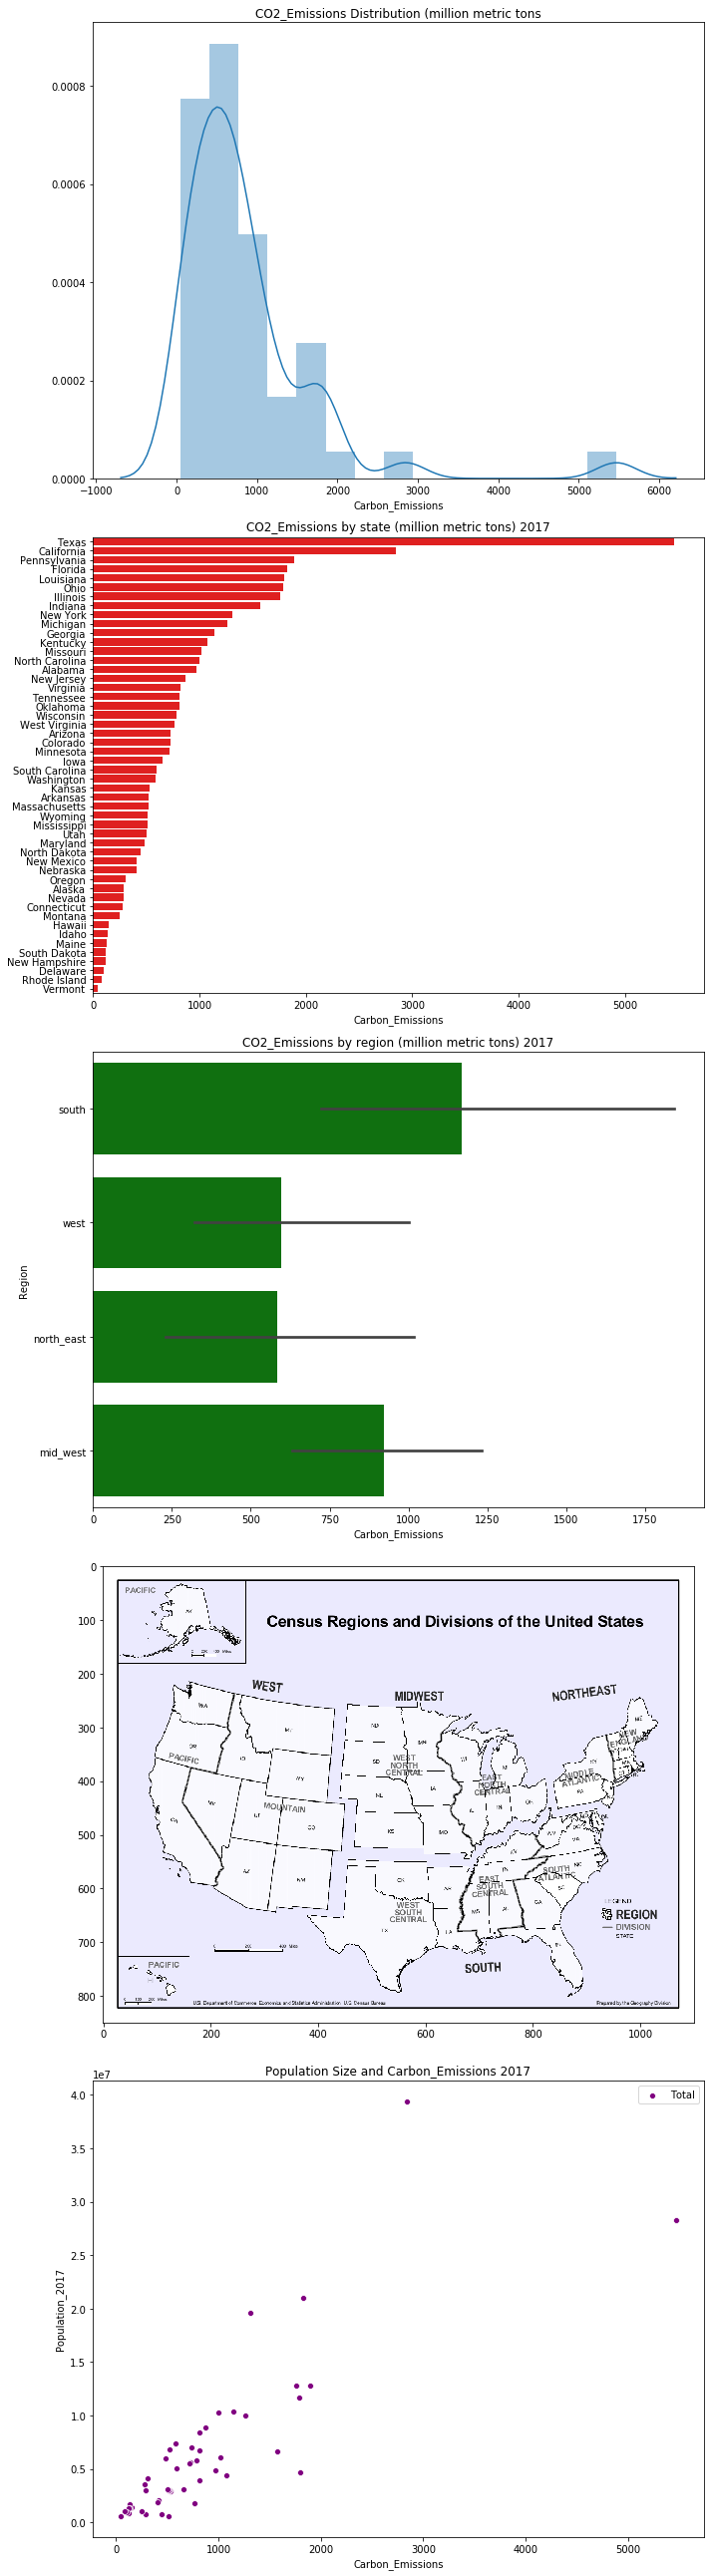

In [245]:
%run -i "scripts//visuals_data_exploring.py"

# Hypothesis Tests I
       -Ho: The carbon emission for south, west, mid_west, north_east regions are 37%, 23%, 21%, 17%, respectively
       -Ha: At least one of the proportions in the null hypothesis is false.

### Chi Square Test Goodness of Fit
     Test was choosen to see if the population size by region was consistent the carbon emissions by region.
**_Conclusion_**: 
    
     P-Value = 0.99
     Alpha-Value = 0.05
    
    -Given 0.99 is greater than 0.05, We do not reject the Ho. 
    -There is no significant realationship between population size and carbon emissions

In [250]:
%run -i "scripts//hypothesis_1.py"

Power_divergenceResult(statistic=0.04872015745947898, pvalue=0.9971813379692855)


# Hypothesis Tests II
   
    -Ho: The Carbon Emissions mean = Year mean = State mean
    -Ha: The means are not all equal

### ANOVA Test 
     Test was choosen to see if the year, state, and carbon emissions were related.
     
**_Conclusion_**: 
    
     P-Value-year = 1.356580e-13
     P-Value-State = 0.000000e+00
     Alpha-Value = 0.05
    
    -Given  P-Value-year & P-Value-State are less than Alpha-Value, We reject the Ho. 
    -The year and states have significant relation to carbon emissions

In [270]:
%run -i "scripts//hypothesis_2.py"

                sum_sq     df            F        PR(>F)
C(State)  4.829512e+06   49.0  2674.428830  0.000000e+00
C(Year)   3.070503e+03    7.0    11.902425  1.356580e-13
Residual  1.264067e+04  343.0          NaN           NaN


# Confident Intervals